In [42]:
!pip install seaborn

In [43]:
!pip install matplotlib

In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve,precision_recall_curve,auc  # Import metrics
import shap
import pickle
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('1_prep_data.csv')
data.shape

(9997, 13)

In [3]:
data.Exited.value_counts()

Exited
0    7960
1    2037
Name: count, dtype: int64

In [6]:
# x_test.columns

In [7]:
from sklearn.model_selection import train_test_split
y = data['Exited']
X = data.drop(['Exited','Age','CreditScore','CustomerId','CreditScore_Custom'],axis=1)
X['is_zero_balance'] = np.where(X.Balance == 0,1,0)
cat_variables =  [col for col in X.columns if X[col].dtype == 'O']
other_variables = list(set(X.columns.to_list()) - set(cat_variables))

final_cols = cat_variables+other_variables
X = X[final_cols]
print(X.columns)

primary_key = data['CustomerId']
x_train, x_temp, y_train, y_temp,test_primary_key,temp_primary_key = train_test_split(X, y,primary_key, test_size=0.2, random_state=42, stratify=y)

x_test, x_oos, y_test, y_oos,test_primary_key,oos_primary_key = train_test_split(x_temp, y_temp,temp_primary_key, test_size=0.5, random_state=42, stratify=y_temp)

# Now you have your three datasets:
print(f"Training set size: X_train={x_train.shape}, y_train={y_train.shape}")
print(f"Testing set size: X_test={x_test.shape}, y_test={y_test.shape}")
print(f"Out-of-sample set size: X_oos={x_oos.shape}, y_oos={y_oos.shape}")

Index(['Geography', 'Gender', 'Age_Group_Custom', 'EstimatedSalary', 'Balance',
       'IsActiveMember', 'NumOfProducts', 'is_zero_balance', 'Tenure'],
      dtype='object')
Training set size: X_train=(7997, 9), y_train=(7997,)
Testing set size: X_test=(1000, 9), y_test=(1000,)
Out-of-sample set size: X_oos=(1000, 9), y_oos=(1000,)


In [8]:
x_test.join(y_test).to_csv('x_test.csv',index  =False)

In [9]:
x_oos.join(y_oos).to_csv('x_oos.csv',index  =False)

In [10]:
data['NumOfProducts'].value_counts()

NumOfProducts
1    5081
2    4590
3     266
4      60
Name: count, dtype: int64

In [11]:
numeric_columns = [col for col in x_train.columns if x_train[col].dtype != 'O' and col!='CustomerId']
numeric_columns
categorical_columns = [col for col in x_train.columns if x_train[col].dtype == 'O']
print(categorical_columns)

['Geography', 'Gender', 'Age_Group_Custom']


In [12]:
numeric_columns

['EstimatedSalary',
 'Balance',
 'IsActiveMember',
 'NumOfProducts',
 'is_zero_balance',
 'Tenure']

In [13]:
log_transform_cols = ['EstimatedSalary', 'Balance']
# log_transform_cols = numeric_columns

In [14]:
labels_endcode = ['Gender']
one_hot_labels = [val for val in categorical_columns if val not in labels_endcode]
print(labels_endcode,one_hot_labels)


['Gender'] ['Geography', 'Age_Group_Custom']


In [15]:
cat_variables =  [col for col in x_train.columns if x_train[col].dtype == 'O']
other_variables = list(set(x_train.columns.to_list()) - set(categorical_columns))

final_cols = cat_variables+other_variables
x_train = x_train[final_cols]
x_train.columns

Index(['Geography', 'Gender', 'Age_Group_Custom', 'EstimatedSalary', 'Balance',
       'IsActiveMember', 'NumOfProducts', 'is_zero_balance', 'Tenure'],
      dtype='object')

In [16]:
y_train.value_counts()

Exited
0    6368
1    1629
Name: count, dtype: int64

In [17]:
y_test.value_counts()

Exited
0    796
1    204
Name: count, dtype: int64

In [18]:
# --- 1. Define Preprocessing Steps ---

# --- 1.1.  Label Encoding ---
label_encode_processor = Pipeline(
    steps=[
         ("label_encoder", OrdinalEncoder()),
    ]
)

# --- 1.2. One-Hot Encoding ---
onehot_encode_processor = Pipeline(
    steps=[
        ("onehot_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

# --- 1.3. Log Transformation ---
def log_transform(x):
    # Handle non-positive values by adding a small constant
    x_adjusted = np.where(x <= 0, 1e-6, x)
    return np.log(x_adjusted)

log_transform_processor = Pipeline(
    steps=[
        ("log_transformer", FunctionTransformer(log_transform)),
    ]
)
# --- 2.  Column Transformer ---
# Apply the different transformations to the specified columns
preprocessor = ColumnTransformer(
    transformers=[
        ("label_encode", label_encode_processor, labels_endcode),
        ("onehot_encode", onehot_encode_processor, one_hot_labels),
        ("log_transform", log_transform_processor, log_transform_cols),
    ],
    remainder="passthrough",  # Keep the remaining columns as is
)

# --- 3.  Pipeline ---
# Combine the preprocessor with optional missing value handling

positive_class_count = np.sum(y_train == 1)
negative_class_count = np.sum(y_train == 0)
scale_pos_weight = negative_class_count / positive_class_count

model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),("model",CatBoostClassifier(scale_pos_weight=scale_pos_weight))])



In [19]:
cat_model = model_pipeline.fit(x_train,y_train)

Learning rate set to 0.025031
0:	learn: 0.6817023	total: 199ms	remaining: 3m 19s
1:	learn: 0.6701216	total: 205ms	remaining: 1m 42s
2:	learn: 0.6593292	total: 209ms	remaining: 1m 9s
3:	learn: 0.6502798	total: 214ms	remaining: 53.4s
4:	learn: 0.6434654	total: 219ms	remaining: 43.5s
5:	learn: 0.6353408	total: 223ms	remaining: 37s
6:	learn: 0.6266279	total: 228ms	remaining: 32.3s
7:	learn: 0.6206137	total: 232ms	remaining: 28.8s
8:	learn: 0.6137706	total: 237ms	remaining: 26.1s
9:	learn: 0.6063824	total: 241ms	remaining: 23.9s
10:	learn: 0.5996310	total: 246ms	remaining: 22.1s
11:	learn: 0.5930208	total: 251ms	remaining: 20.6s
12:	learn: 0.5869747	total: 255ms	remaining: 19.4s
13:	learn: 0.5835122	total: 260ms	remaining: 18.3s
14:	learn: 0.5795825	total: 264ms	remaining: 17.4s
15:	learn: 0.5757612	total: 269ms	remaining: 16.5s
16:	learn: 0.5720487	total: 274ms	remaining: 15.8s
17:	learn: 0.5675497	total: 279ms	remaining: 15.2s
18:	learn: 0.5642356	total: 283ms	remaining: 14.6s
19:	learn: 

Model saved as bank_churn_mod_v2.pkl


In [20]:
y_pred = cat_model.predict(x_test)
y_prob = cat_model.predict_proba(x_test)[:,1]

results_df = pd.DataFrame(
    {"customer_id": test_primary_key, "prediction": y_pred, "actual": y_test}
)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
print(f"specificity: {specificity:.4f}")
# --- 13. Calculate and Print Performance Metrics ---
print("\n--- CatBoost Performance ---")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

cm = confusion_matrix(y_test,y_pred)
print(cm)

specificity: 0.8317

--- CatBoost Performance ---
              precision    recall  f1-score   support

           0       0.92      0.83      0.88       796
           1       0.53      0.74      0.61       204

    accuracy                           0.81      1000
   macro avg       0.73      0.78      0.75      1000
weighted avg       0.84      0.81      0.82      1000

Accuracy: 0.8120
Precision: 0.5282
Recall: 0.7353
F1 Score: 0.6148
ROC AUC: 0.8557
[[662 134]
 [ 54 150]]


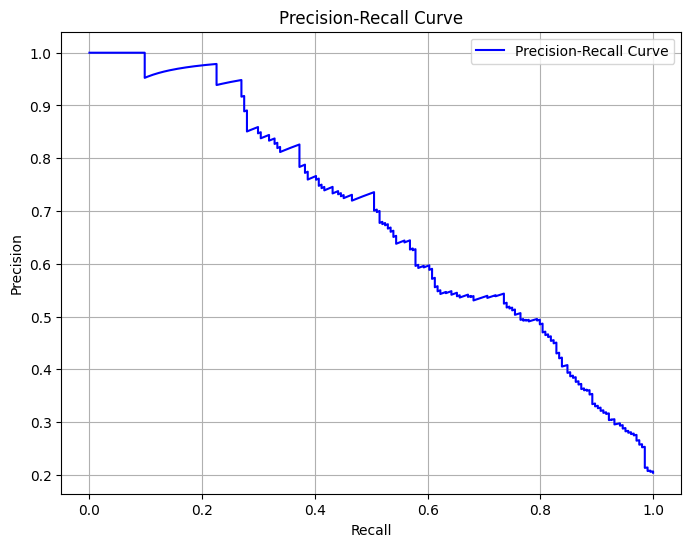

In [21]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
# 5. Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend(loc='best')


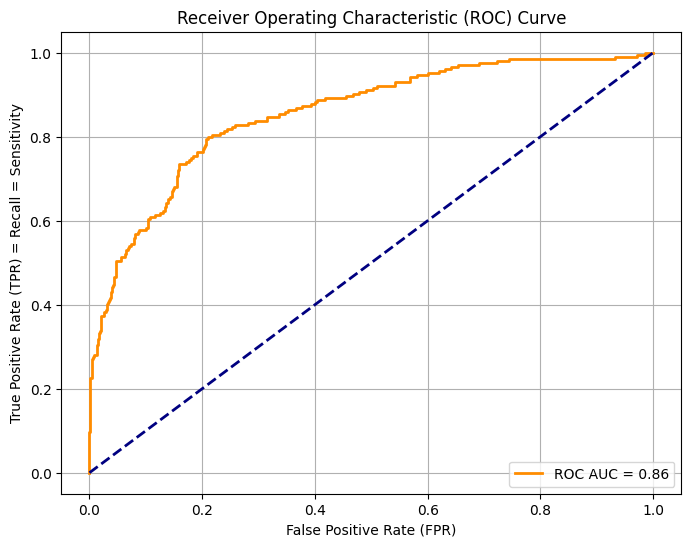

In [22]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) = Recall = Sensitivity')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The code you've been using calculates and plots the ROC curve and AUC.  An AUC of 0.8543 suggests that the model you've trained is effective at identifying customers at risk of churn. This is a positive result, indicating that the model has the potential to be valuable for your bank in implementing churn prevention strategies.

In [ ]:

import pickle
filename = 'bank_churn_mod_v2.pkl'

# Open a file in binary write ('wb') mode
with open(filename, 'wb') as file:
    pickle.dump(cat_model, file)

print(f"Model saved as {filename}")


In [65]:
len(precision)

1001

In [66]:
len(recall)

1001

In [67]:
# 6. Find the Threshold for Precision >= 0.6
# We iterate through the precision values and find the first one that meets our condition
desired_precision = .6
threshold_for_desired_precision = None
desired_recall = .7
recall_at_desired_precision = None

for i in range(len(precision)):
    if precision[i] >= desired_precision and  recall[i] >= desired_recall:
        threshold_for_desired_precision = thresholds[i]
        recall_at_desired_precision = recall[i]
        break  # Stop once we find the first suitable threshold

if threshold_for_desired_precision is not None:
    print(
        f"Threshold for Precision >= {desired_precision * 100}%: {threshold_for_desired_precision:.3f}"
    )
    print(f"Precision at this Threshold: {precision[i]:.3f}")
    print(f"Recall at this Threshold: {recall_at_desired_precision:.3f}")

    # Plot the point on the curve
    plt.plot(
        recall_at_desired_precision,
        precision[i],
        'ro',
        label=f'Precision >= {desired_precision * 100}%',
    )
    plt.annotate(
        f'Threshold = {threshold_for_desired_precision:.3f}',
        xy=(recall_at_desired_precision, precision[i]),
        xytext=(recall_at_desired_precision + 0.1, precision[i] - 0.05),  # Adjust text position
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
    )
    plt.legend(loc='best')
else:
    print(
        f"No threshold found that satisfies Precision >= {desired_precision * 100}%"
    )

plt.show()


No threshold found that satisfies Precision >= 60.0%


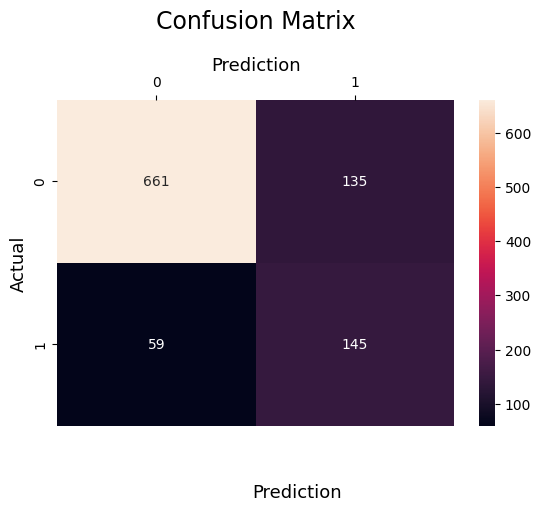

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm, 
            annot=True,
            fmt='g', )
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

In [69]:
TP = 145
FP = 130
FN = 59
TN = 666

130/(145+59)

0.6372549019607843


--- SHAP Analysis ---
['Gender', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Age_Group_Custom_Adult', 'Age_Group_Custom_Middle-Aged', 'Age_Group_Custom_Senior', 'Age_Group_Custom_Very Senior', 'Age_Group_Custom_Young Adult', 'EstimatedSalary', 'Balance', 'IsActiveMember', 'Tenure', 'NumOfProducts']
['Gender', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Age_Group_Custom_Adult', 'Age_Group_Custom_Middle-Aged', 'Age_Group_Custom_Senior', 'Age_Group_Custom_Very Senior', 'Age_Group_Custom_Young Adult', 'EstimatedSalary', 'Balance', 'IsActiveMember', 'Tenure', 'NumOfProducts']


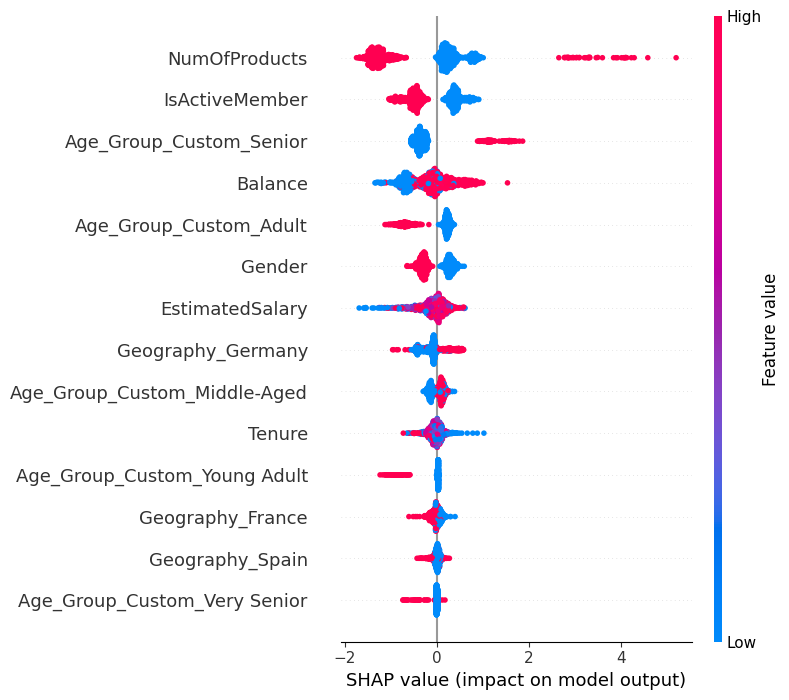

In [70]:
print("\n--- SHAP Analysis ---")
feature_names_after_onehot = cat_model.named_steps['preprocessor'].named_transformers_['onehot_encode']['onehot_encoder'].get_feature_names_out(input_features=one_hot_labels)
onehot_cols = list(feature_names_after_onehot)
# Get column names after transformation
original_columns = list(X.columns)
feature_names = (
    labels_endcode
    +onehot_cols
    + log_transform_cols
    + [col for col in original_columns if col not in labels_endcode + onehot_cols + log_transform_cols + one_hot_labels]
)
print(feature_names)
X_train_processed = pd.DataFrame(cat_model.named_steps['preprocessor'].transform(x_train),columns=feature_names) # Use the saved pipeline

X_test_processed = pd.DataFrame(cat_model.named_steps['preprocessor'].transform(x_test),columns=feature_names)


print(feature_names)


# Use TreeExplainer for CatBoost
explainer = shap.TreeExplainer(
    cat_model.named_steps["model"]
)  # Changed to TreeExplainer
shap_values = explainer.shap_values(X_test_processed)

# Visualize the feature importance
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names)

In [74]:
X_test_processed.columns

Index(['Gender', 'Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Age_Group_Custom_Adult', 'Age_Group_Custom_Middle-Aged',
       'Age_Group_Custom_Senior', 'Age_Group_Custom_Very Senior',
       'Age_Group_Custom_Young Adult', 'EstimatedSalary', 'Balance',
       'IsActiveMember', 'Tenure', 'NumOfProducts'],
      dtype='object')

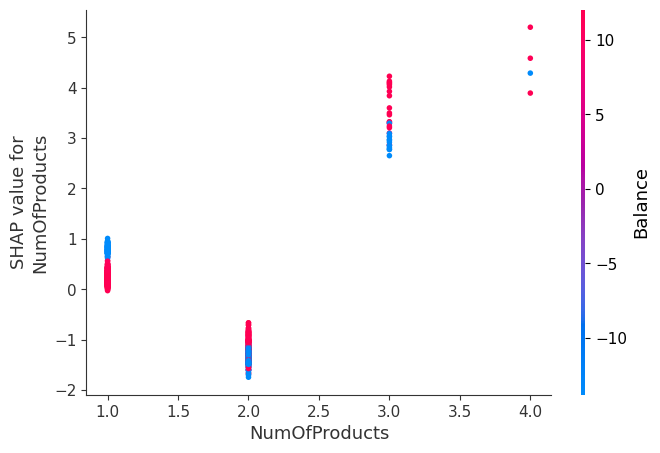

In [76]:
shap.dependence_plot("NumOfProducts", shap_values, X_test_processed, show=False)

In [71]:

shap.plots.waterfall(shap_values[0])

TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.

In [ ]:
# Let's break down this beeswarm plot, which is a common way to visualize SHAP (SHapley Additive exPlanations) values from a machine learning model.

# What the Plot Shows:

# Features (y-axis): The features used by your model are listed on the left-hand side (e.g., NumOfProducts, IsActiveMember, Age_Group_Custom_Senior, etc.). The features are typically ordered by their importance (though this isn't always the case).
# SHAP Value (x-axis): The horizontal axis represents the SHAP value.
# A positive SHAP value means that the feature's value pushes the model's output higher.
# A negative SHAP value means that the feature's value pushes the model's output lower.
# A SHAP value of zero means the feature has no impact on the output for that specific instance.
# Dots: Each dot on the plot represents a single instance (a row in your data). The color of the dot indicates the value of that feature for that instance (as shown by the color bar on the right).
# Red typically indicates a high value of the feature.
# Blue typically indicates a low value of the feature.
# Distribution: The horizontal spread of the dots for each feature shows the distribution of the impact of that feature across the dataset. A wider spread indicates that the feature has a more varied impact on the model's output depending on its value and the values of other features.
# Interpreting the Features:

# Let's go through some of the features in your plot:

# NumOfProducts:

# High values (red dots, likely meaning more products) tend to have a negative SHAP value, pushing the model's output lower.
# Low values (blue dots, likely meaning fewer products) tend to have a positive SHAP value, pushing the model's output higher.
# This suggests that having more products is associated with a lower model output (whatever the model is predicting).
# IsActiveMember:

# High values (red dots, likely meaning the customer is an active member) tend to have a positive SHAP value.
# Low values (blue dots, likely meaning the customer is not an active member) tend to have a negative SHAP value.
# This indicates that being an active member increases the model's output.
# Age_Group_Custom_Senior:

# High values (red dots, indicating the customer belongs to the "Senior" age group) tend to have a positive SHAP value.
# Low values (blue dots, indicating the customer does not belong to this group) tend to have a negative SHAP value.
# This suggests that being in the "Senior" age group increases the model's output.
# Balance:

# The impact of Balance seems more complex. Both high (red) and low (blue) values appear on both sides of the zero SHAP value line, though there's a concentration of red dots with positive SHAP values. This suggests that having a certain range of balance might positively influence the model output, but the relationship isn't strictly linear.
# Gender:

# The impact of Gender appears relatively small compared to other features, with SHAP values clustered closer to zero. The color coding (assuming red for one gender and blue for the other) shows a slight tendency in one direction, but it's not as strong as for features like NumOfProducts or IsActiveMember.
# EstimatedSalary:

# Similar to Balance, the impact of EstimatedSalary isn't strictly monotonic. Both high and low salaries have instances with positive and negative SHAP values, although there's a slight tendency for higher salaries (red) to have slightly positive impacts for some instances.
# Geography_Germany, Geography_France, Geography_Spain:

# These features represent the geographical location. For example, for Geography_Germany, red dots (customers in Germany) tend to have positive SHAP values, suggesting that being in Germany increases the model's output. You can interpret France and Spain similarly.
# Tenure:

# The impact of Tenure (how long the customer has been with the bank) seems to be mostly centered around zero, indicating a relatively weaker overall impact compared to some other features.
# In Summary:

# This beeswarm plot helps you understand:

# Which features are most important (those with the widest horizontal spread of SHAP values).
# How each feature affects the model's output (direction of the SHAP values).
# How the feature's value influences its impact (color of the dots).
# To give you a more precise interpretation, knowing what the model is predicting would be helpful. For example, is it predicting customer churn, loan default, or something else?

# Do you have a specific feature you'd like a more detailed explanation of?

In [ ]:
# x_train.Gender.value_counts()


Gender
Male      4358
Female    3639
Name: count, dtype: int64

In [ ]:
# X_train_processed.Gender.value_counts()

Gender
1.0    4358
0.0    3639
Name: count, dtype: int64

In [ ]:
explainer = shap.Explainer(cat_model.named_steps["model"])
print(explainer)

In [ ]:
shap_values_1 = explainer(X_test_processed)

In [ ]:
np.shape(shap_values_1.values)

(1000, 14)

In [ ]:
# shap_values_1

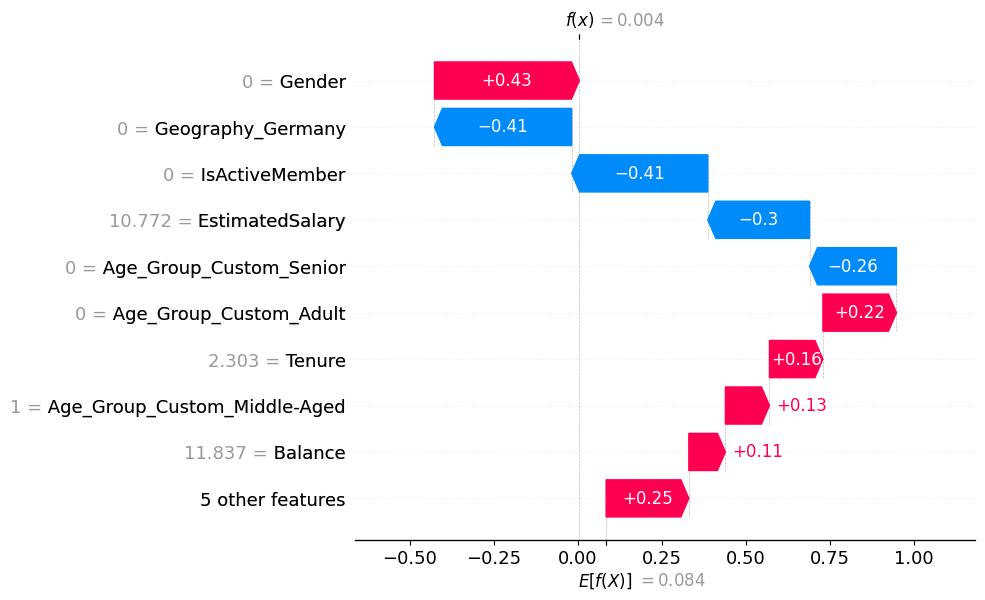

In [ ]:
shap.plots.waterfall(shap_values_1[0])

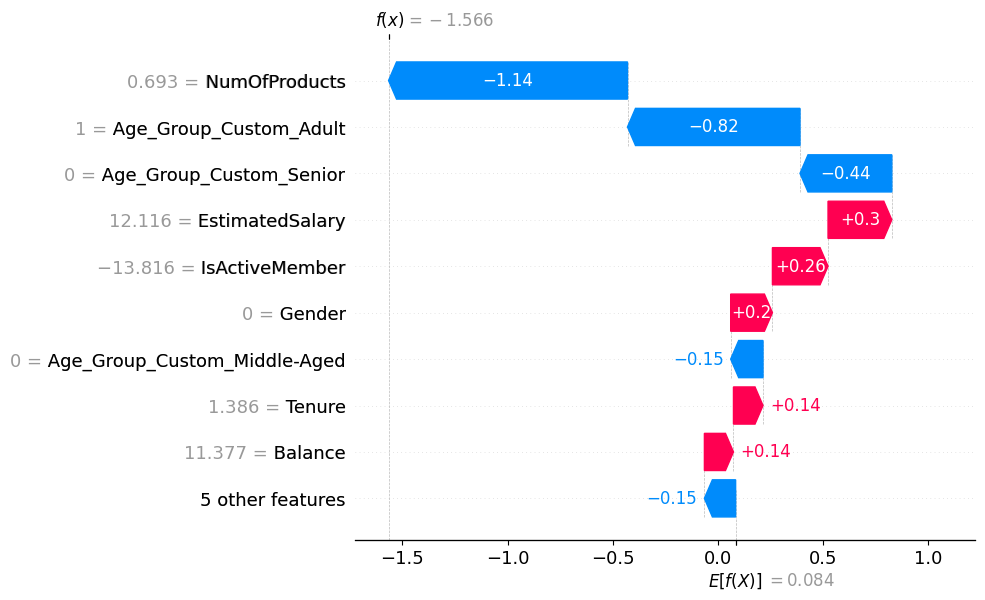

In [ ]:
shap.plots.waterfall(shap_values_1[5])

In [ ]:
((1/3)*5000)+((1/3)*5000)+((1/6)*2500)+((1/6)*7500)

5000.0

In [ ]:
((1/6)*2500)+((1/6)*0)+((1/3)*0)+((1/3)*2500)

1250.0

In [ ]:
((1/6)*2500)+((1/6)*5000)+((1/3)*2500)+((1/3)*5000)

3749.9999999999995